# ORENIST Classification Example

**Note**: This notebook is designed to run on CPU (no GPU) runtime.

**[OCE-01]**

Install libraries.

In [ ]:
%%bash
curl -sLO https://raw.githubusercontent.com/enakai00/colab_jaxbook/main/requirements.txt
pip install -qr requirements.txt
pip list | grep -E '(jax|flax|optax)'

flax                          0.6.1
jax                           0.3.21
jaxlib                        0.3.15+cuda11.cudnn805
optax                         0.1.3


**[OCE-02]**

Import modules.

In [ ]:
import numpy as np 
import matplotlib.pyplot as plt
from pandas import DataFrame
import pickle

import jax, optax
from jax import random, numpy as jnp
from flax import linen as nn
from flax.training import train_state
from flax.core.frozen_dict import freeze, unfreeze

plt.rcParams.update({'font.size': 12})

**[OCE-03]**

Download ORENIST dataset and convert to DeviceArray objects.

In [ ]:
!curl -LO https://github.com/enakai00/colab_jaxbook/raw/main/Chapter04/ORENIST.pkl
with open('ORENIST.pkl', 'rb') as file:
    images, labels = pickle.load(file)
images = jnp.asarray(images)
labels = jnp.asarray(labels)

  % Total    % Received % Xferd  Average Speed   Time    Time     Time  Current
                                 Dload  Upload   Total   Spent    Left  Speed
  0     0    0     0    0     0      0      0 --:--:-- --:--:-- --:--:--     0
100  553k  100  553k    0     0  1284k      0 --:--:-- --:--:-- --:--:-- 1284k


**[OCE-04]**

Prepare the fixed convolutional filters and store them in `filter_array`.

In [ ]:
filter0 = np.array([[ 2, 1, 0,-1,-2],
                    [ 3, 2, 0,-2,-3],
                    [ 4, 3, 0,-3,-4],
                    [ 3, 2, 0,-2,-3],
                    [ 2, 1, 0,-1,-2]]) / 23.0
filter1 = np.array([[ 2, 3, 4, 3, 2],
                    [ 1, 2, 3, 2, 1],
                    [ 0, 0, 0, 0, 0],
                    [-1,-2,-3,-2,-1],
                    [-2,-3,-4,-3,-2]]) / 23.0

filter_array = np.zeros([5, 5, 1, 2])
filter_array[:, :, 0, 0] = filter0
filter_array[:, :, 0, 1] = filter1

**[OCE-05]**

Define a classification model with the static convolutional filter.

In [ ]:
class StaticFilterClassificationModel(nn.Module):
    @nn.compact
    def __call__(self, x, get_logits=False, get_hidden_output=False):
        x = x.reshape([-1, 28, 28, 1])
        x = nn.Conv(features=2, kernel_size=(5, 5), use_bias=False,
                    name='StaticConv')(x)
        x = jnp.abs(x)
        x = nn.relu(x-0.2)
        x = nn.max_pool(x, window_shape=(2, 2), strides=(2, 2))
        x = x.reshape([x.shape[0], -1]) # Flatten
        x = nn.Dense(features=2)(x)
        x = nn.tanh(x)
        if get_hidden_output:
            return x
        x = nn.Dense(features=3)(x)
        if get_logits:
            return x
        x = nn.softmax(x)
        return x

**[OCE-06]**

Generate initial parameter values.

In [ ]:
key, key1 = random.split(random.PRNGKey(0))
variables = StaticFilterClassificationModel().init(key1, images[0:1])

jax.tree_util.tree_map(lambda x: x.shape, variables['params'])

FrozenDict({
    Dense_0: {
        bias: (2,),
        kernel: (392, 2),
    },
    Dense_1: {
        bias: (3,),
        kernel: (2, 3),
    },
    StaticConv: {
        kernel: (5, 5, 1, 2),
    },
})

**[OCE-07]**

Update parameter values with the fixed convolutional filters.

In [ ]:
params = unfreeze(variables['params'])
params['StaticConv']['kernel'] = jnp.asarray(filter_array)
new_params = freeze(params)

**[OCE-08]**

Create a parameter mask with the default `True` values.

In [ ]:
params_mask = jax.tree_util.tree_map(lambda x: True, new_params)
params_mask

FrozenDict({
    Dense_0: {
        bias: True,
        kernel: True,
    },
    Dense_1: {
        bias: True,
        kernel: True,
    },
    StaticConv: {
        kernel: True,
    },
})

**[OCE-09]**

Update the parameter mask to freeze the parameter values for the convolutional filters.

In [ ]:
params_mask = unfreeze(params_mask)
params_mask['StaticConv']['kernel'] = False
params_mask = freeze(params_mask)
params_mask

FrozenDict({
    Dense_0: {
        bias: True,
        kernel: True,
    },
    Dense_1: {
        bias: True,
        kernel: True,
    },
    StaticConv: {
        kernel: False,
    },
})

**[OCE-10]**

Create a TrainState object with the multi-transform optimizer that applies the parameter mask.

In [ ]:
zero_grads = optax.GradientTransformation(
    # init_fn(_)
    lambda x: (),
    # update_fn(updates, state, params=None)
    lambda updates, state, params: (jax.tree_map(jnp.zeros_like, updates), ()))

optimizer = optax.multi_transform(
    {True: optax.adam(learning_rate=0.001), False: zero_grads},
    params_mask)

state = train_state.TrainState.create(
    apply_fn=StaticFilterClassificationModel().apply,
    params=new_params,
    tx=optimizer)

**[OCE-11]**

Define a loss function as the categorical cross entoropy.

In [ ]:
@jax.jit
def loss_fn(params, state, inputs, labels):
    logits = state.apply_fn({'params': params}, inputs, get_logits=True)
    loss = optax.softmax_cross_entropy(logits, labels).mean()
    acc = jnp.mean(jnp.argmax(logits, -1) == jnp.argmax(labels, -1))
    return loss, acc

**[OCE-12]**

Define a function to apply the training steps for one epoch.

In [ ]:
@jax.jit
def train_step(state, inputs, labels):
    (loss, acc), grads = jax.value_and_grad(loss_fn, has_aux=True)(
        state.params, state, inputs, labels)
    new_state = state.apply_gradients(grads=grads)
    return new_state, loss, acc

**[OCE-13]**

Repeat applying the training step.

In [ ]:
%%time
loss_history, acc_history = [], []
hidden_vals_history = []
for step in range(1, 201):
    state, loss, acc = train_step(state, images, labels)
    loss_history.append(jax.device_get(loss).tolist())
    acc_history.append(jax.device_get(acc).tolist())

    hidden_vals = jax.device_get(
        state.apply_fn({'params': state.params}, images,
                       get_hidden_output=True))
    hidden_vals_history.append(hidden_vals)

    if step % 20 == 0:
        print ('Step: {}, Loss: {:.4f}, Accuracy {:.4f}'.format(
            step, loss, acc), flush=True)

Step: 20, Loss: 0.9684, Accuracy 0.6889
Step: 40, Loss: 0.8513, Accuracy 0.9889
Step: 60, Loss: 0.7738, Accuracy 0.9889
Step: 80, Loss: 0.7144, Accuracy 1.0000
Step: 100, Loss: 0.6660, Accuracy 1.0000
Step: 120, Loss: 0.6254, Accuracy 1.0000
Step: 140, Loss: 0.5905, Accuracy 1.0000
Step: 160, Loss: 0.5599, Accuracy 1.0000
Step: 180, Loss: 0.5327, Accuracy 1.0000
Step: 200, Loss: 0.5082, Accuracy 1.0000
CPU times: user 34.4 s, sys: 275 ms, total: 34.6 s
Wall time: 33.6 s


**[OCE-14]**

Show charts of loss history / accuracy history.

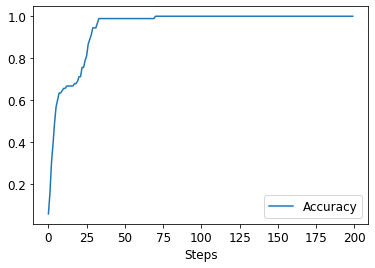

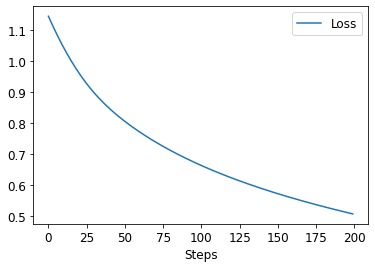

In [ ]:
df = DataFrame({'Accuracy': acc_history})
df.index.name = 'Steps'
_ = df.plot(figsize=(6, 4))

df = DataFrame({'Loss': loss_history})
df.index.name = 'Steps'
_ = df.plot(figsize=(6, 4))

**[OCE-15]**

Show the scatter chart of the hidden layer features.

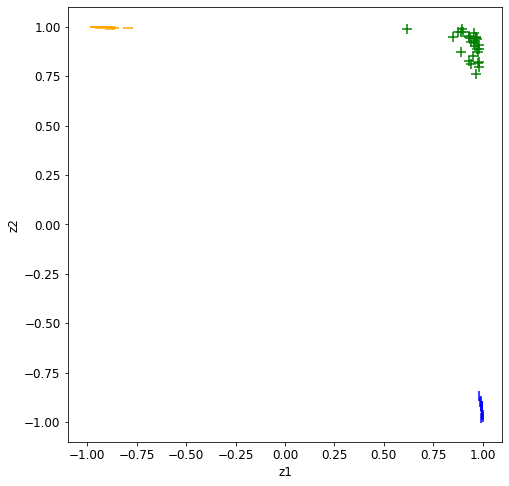

In [ ]:
def show_hidden_vals(subplot, hidden_vals):
    z1_vals = [[],[],[]]
    z2_vals = [[],[],[]]

    for hidden_val, label in zip(hidden_vals, labels):
        label_num = np.argmax(label)
        z1_vals[label_num].append(hidden_val[0])
        z2_vals[label_num].append(hidden_val[1])

    subplot.set_xlim([-1.1, 1.1])
    subplot.set_ylim([-1.1, 1.1])
    subplot.set_aspect('equal')
    a = subplot.scatter(z1_vals[0], z2_vals[0],
                        s=100, marker='|', color='blue')
    b = subplot.scatter(z1_vals[1], z2_vals[1],
                        s=100, marker='_', color='orange')
    c = subplot.scatter(z1_vals[2], z2_vals[2],
                        s=100, marker='+', color='green')
    return [a, b, c]


hidden_vals = state.apply_fn(
    {'params': state.params}, images, get_hidden_output=True)
fig = plt.figure(figsize=(8, 8))
subplot = fig.add_subplot(1, 1, 1)
subplot.set_xlabel('z1')
subplot.set_ylabel('z2')
_ = show_hidden_vals(subplot, hidden_vals)

**[OCE-16]**

Show transition of the feature values.


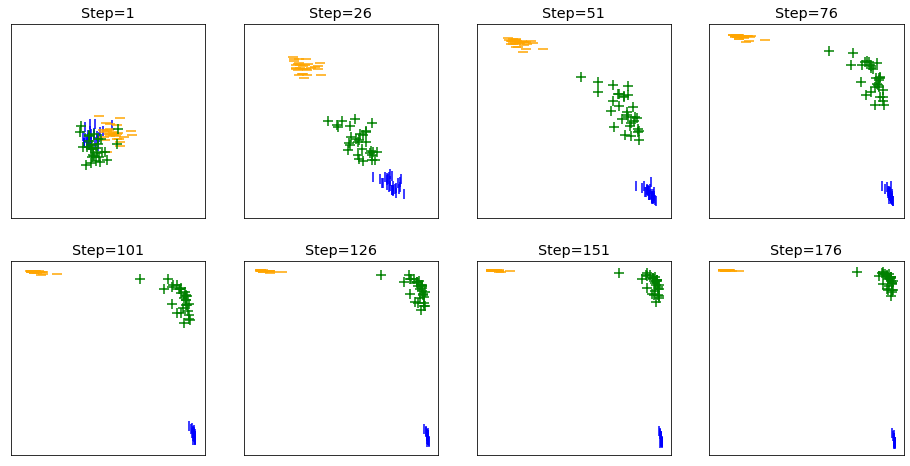

In [ ]:
fig = plt.figure(figsize=(16, 8))
for c, step in enumerate(range(0, 200, 25)):
    hidden_vals = hidden_vals_history[step]
    subplot = fig.add_subplot(2, 4, c+1)
    subplot.set_xticks([])
    subplot.set_yticks([])
    subplot.set_title('Step={}'.format(step+1))
    _ = show_hidden_vals(subplot, hidden_vals)

**[OCE-17]**

Create an animation of the feature tansition.

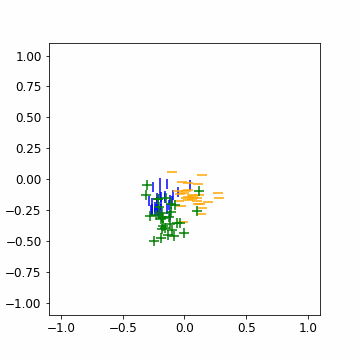

<Figure size 360x360 with 0 Axes>

In [ ]:
import matplotlib.animation as animation
from IPython.display import Image

fig = plt.figure(figsize=(5, 5))
subplot = fig.add_subplot(1, 1, 1)

frames = []
for hidden_vals in hidden_vals_history:
    frames.append(show_hidden_vals(subplot, hidden_vals))
ani = animation.ArtistAnimation(fig, frames, interval=80)
ani.save('hidden_vals_transition.gif', writer='pillow')
plt.clf()

Image('hidden_vals_transition.gif')